# Unsupervised methods for neural data analysis #

Liberty Hamilton

ECI 2018 Lab 2, 27/7/18

## How to run this notebook ##

To run the code, navigate to each cell and press "shift-Enter" to run, or click the run button at the top of the notebook. 

If the cell is running, you will see "`In [*]`", and when the cell is finished running, you will see a number corresponding to the iteration number (e.g. "`In [2]`").

## What we will learn ##

In this notebook, we will apply convex non-negative matrix factorization to the same dataset that we looked at in Lab 1.  You will learn how to fit models with different numbers of components, how to find how well they fit the data, and how to interpret what the components might be following in the sound stimulus.

In [1]:
# Load scipy, numpy, matplotlib (for inline graphics)
%pylab
%matplotlib inline

import tables # this is a library for loading hdf5 files
import scipy.io # For loading .mat files (usually from matlab)
import matplotlib.pyplot as plt # For plotting

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# import the data, same neural data as last time
# Load the data files for each representation
dataFile = '../Lab1/data/sample_stim_resp.hf5' # HDF5 file with our response data
with tables.open_file(dataFile) as tf: # open the data file
    resp = tf.root.resp.read() # Loads the high gamma data matrix 
    fs = tf.root.fs.read()[0] # Sampling rate of the data (resp, audstim, and phnstim)

nchans = resp.shape[1] # The number of channels (e.g. electrodes, neurons)

# Let's look at the dimensions of the stimulus matrix
print("Response is %d time points x %d channels\n"%(resp.shape))
print("Sampling rate of the data is %d"%(fs))

Response is 106299 time points x 68 channels

Sampling rate of the data is 100


In [3]:
# Import code to run convex NMF (as in Ding et al. 2010)
from third_party_code.pymf import cnmf

In [4]:
# Decide on the number of basis functions to fit for NMF
nb = 4 # Number of basis functions (or components) to choose

In [5]:
# Perform convex NMF decomposition
nmf_mdl = cnmf.CNMF(resp, num_bases = nb)
nmf_mdl.factorize(niter=30)

## Model convergence ##

To determine whether the NMF factorization has converged, we can look at the sum of the squared error (stored as `nmf_mdl.ferr`) between the estimate of the data based on this reduced dimensionality set and the actual data.

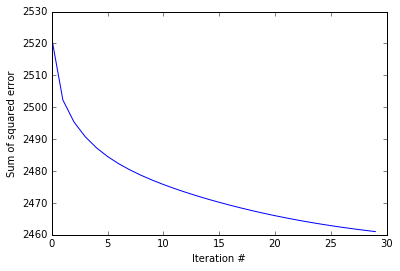

In [6]:
# Let's make sure the model looks like it has converged.
# Usually around 10 iterations is sufficient, but here we are doing a little more.
# Plot the error as a function of the number of iterations of the NMF algorithm
plt.plot(nmf_mdl.ferr)
plt.xlabel('Iteration #')
plt.ylabel('Sum of squared error')

## Responses estimated from NMF components ## 

Now let's take a look at the response matrix (`[time x electrodes]`) that we are trying to estimate from these components and see how similar the response estimate looks to the actual response data.

In [7]:
# How good is this reconstruction?
# The original data matrix is `resp`.  We have estimated `resp` as W*H.  
resp_est = np.dot(nmf_mdl.W, nmf_mdl.H)

In [8]:
# Choose the range of time points we want to look at 
start_sec = 400
end_sec = 450
timebins = np.arange(np.int(start_sec*fs),np.int(end_sec*fs))

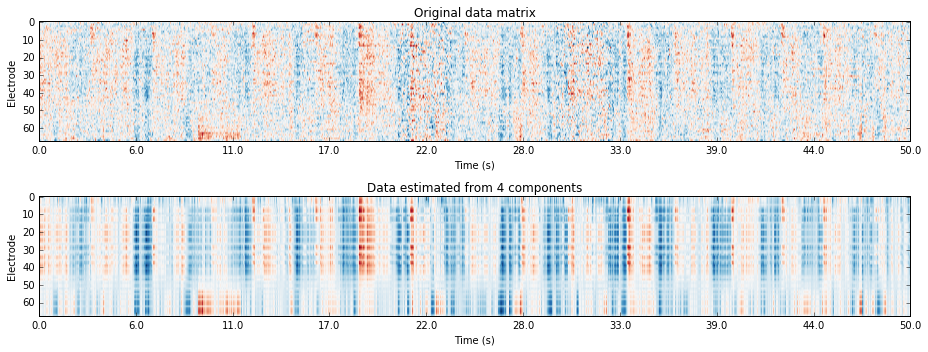

In [9]:
plt.figure(figsize = (13,5))
plt.subplot(2,1,1)
plt.imshow(resp[timebins,:].T, aspect='auto', cmap = cm.RdBu_r)
plt.title('Original data matrix')
plt.ylabel('Electrode')
plt.xlabel('Time (s)')
plt.xticks(np.linspace(0,len(timebins), 10), np.round(np.linspace(0, len(timebins)/fs, 10)))

plt.subplot(2,1,2)
plt.imshow(resp_est[timebins,:].T, aspect='auto', cmap = cm.RdBu_r)
plt.title('Data estimated from %d components'%(nb))
plt.ylabel('Electrode')
plt.xlabel('Time (s)')
plt.xticks(np.linspace(0, len(timebins), 10), np.round(np.linspace(0, len(timebins)/fs, 10)))

plt.tight_layout()

## Question ##

What do you notice about this reconstruction?  Does it look reasonable?  What about it is good or bad / what statistics does it seem to capture?

## What do the components look like? ##

In this version of NMF, we are attempting to decompose a matrix into $D = WH$, where $D$ is the response matrix with dimensions `[time x electrodes]`, $W$ has dimensions `[time x component]`, and $H$ has dimensions `[component x electrodes]`.  

Let's take a look at what these component time series $W$ look like. We can interpret these as canonical population response types across all electrodes (since each represents the activity from a weighted sum of the group of electrodes, defined by the activation matrix $H$.

The W matrix is 106299 time points by 4 components


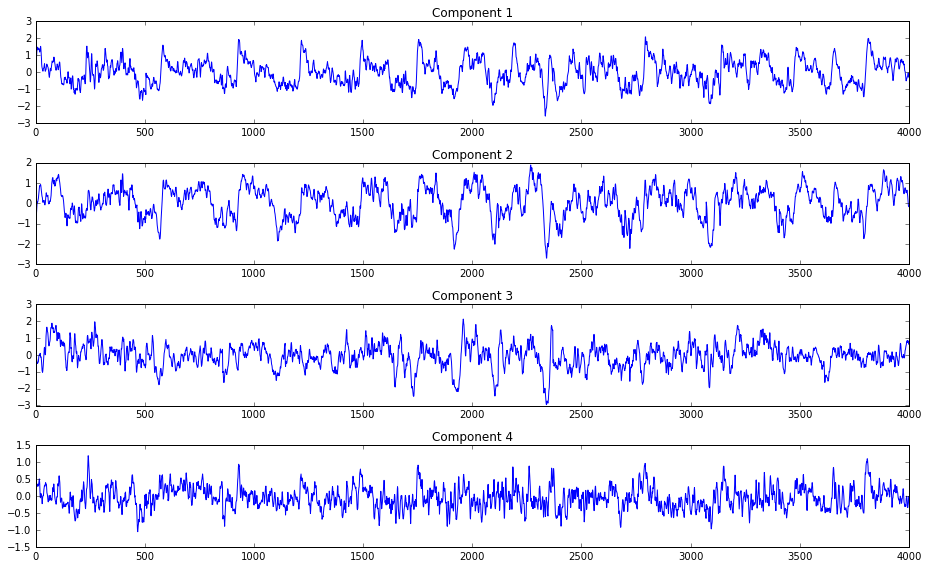

In [12]:
# Let's plot some of the NMF component time series, in this case they are called "W"
# We will make one subplot per NMF component

print("The W matrix is %d time points by %d components"%(nmf_mdl.W.shape[0], nmf_mdl.W.shape[1]))
plt.figure(figsize=(13,2*nb))

for i in np.arange(nb):
    plt.subplot(nb,1,i+1)
    plt.plot(nmf_mdl.W[4000:8000,i])
    plt.gca().set_xlim([0,4000])
    plt.title('Component %d'%(i+1))

plt.tight_layout()

## What are these components responding to? ##

It's difficult to know from these plots what the components are responding to in our input signal.  To make this a bit more intuitive, we will load the sound stimulus and spectrograms again and plot these along with the components.  This is a bit redundant to what's above, but at least it's easier to tell what features the components may be responding to.

In [13]:
# Plot the stimulus as well (spectrogram, for example)
dataFile = '../Lab1/data/sample_stim_spec.hf5' # HDF5 file with our response data
with tables.open_file(dataFile) as tf: # open the data file
    audstim = tf.root.audstim.read() # Loads the spectrogram
    freqs = tf.root.freqs.read() # Center frequencies of spectrogram

dataFile = '../Lab1/data/sample_stim_waveform.hf5' # HDF5 file with our response data
with tables.open_file(dataFile) as tf: # open the data file
    soundstim = tf.root.soundstim.read() # Loads the sound waveform
    sound_fs = tf.root.sound_fs.read() # Load sampling rate of sound waveform 


In [14]:
# Let's play a segment of the sound that we're going to show plots for below
from IPython.display import Audio

# Play an excerpt of the sounds
Audio(data=soundstim[np.int(start_sec*sound_fs):np.int(end_sec*sound_fs)], rate = np.int(sound_fs))

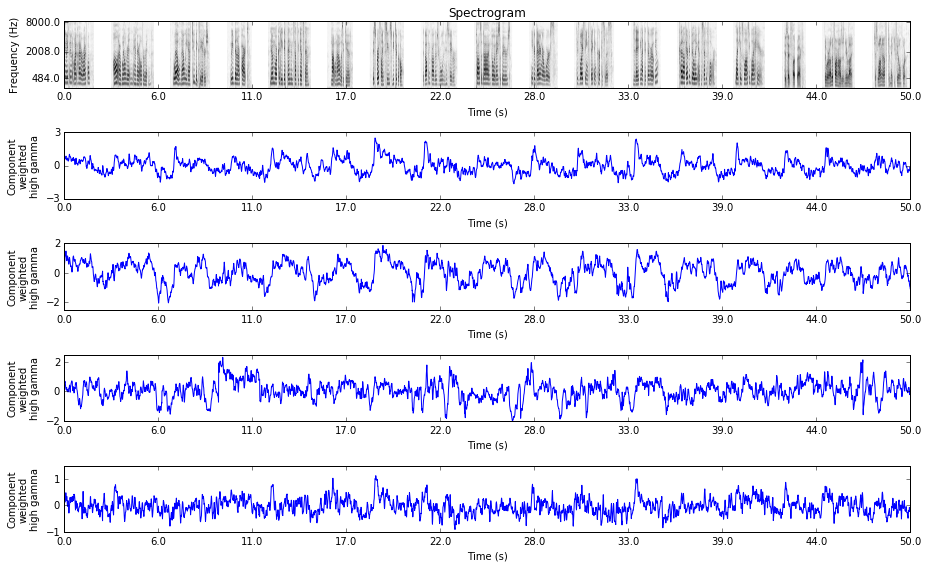

In [16]:
plt.figure(figsize=(13,nb*2))

plt.subplot(nb+1, 1, 1)
plt.imshow(audstim[timebins,:].T, aspect='auto', cmap=cm.Greys)
plt.gca().set_ylim(plt.gca().get_ylim()[::-1]) # This just reverses the y axis so low frequency is at the bottom
plt.gca().set_xlim([0, len(timebins)])
plt.yticks([11,43,79], [np.round(freqs[f]) for f in [11,43,79]])
plt.xticks(np.linspace(0,len(timebins), 10), np.round(np.linspace(0, len(timebins)/fs, 10)))
xlabel('Time (s)')
ylabel('Frequency (Hz)')
#plt.colorbar()
title('Spectrogram')

for i in np.arange(nb):
    component_time_series = nmf_mdl.W[timebins,i]
    cmax = np.max(np.abs(component_time_series))
    plt.subplot(nb+1,1,i+2)
    plt.plot(component_time_series)
    plt.xticks(np.linspace(0,len(timebins), 10), np.round(np.linspace(0, len(timebins)/fs, 10)))
    plt.yticks(np.round([-cmax, 0, cmax]))
    plt.gca().set_xlim([0, len(timebins)])
    xlabel('Time (s)')
    ylabel('Component\nweighted\nhigh gamma')

plt.tight_layout()

## Which electrodes contribute to which components? ##

We can also look at which electrodes contribute to each component. Here we will show the weights across electrodes as a bar graph.

The electrodes are recorded from superior temporal gyrus (STG), and lower electrode numbers are located in the posterior portion of the STG, whereas higher electrode numbers are located in anterior STG.

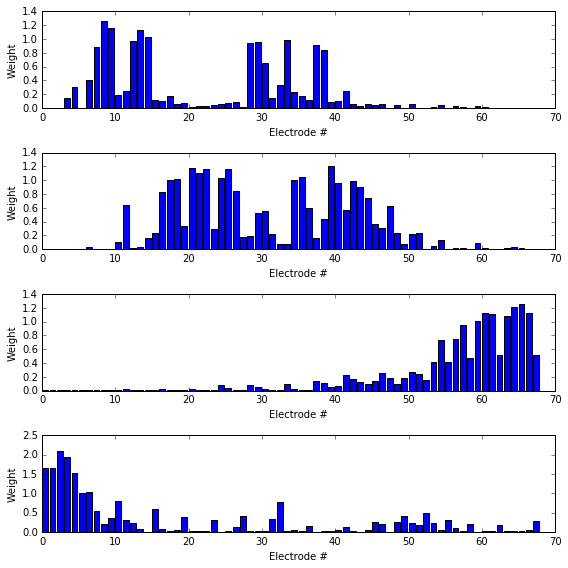

In [17]:
plt.figure(figsize=(8,nb*2))
for i in np.arange(nb):
    component_activation = nmf_mdl.H[i,:]
    plt.subplot(nb, 1, i+1)
    plt.bar(np.arange(len(component_activation)), component_activation)
    plt.xlabel('Electrode #')
    plt.ylabel('Weight')

plt.tight_layout()

## Question ##

What do you notice about how the different electrodes contribute to each of the components?  Does there seem to be any structure? Is there anything else that could help you determine this?

## Combine supervised and unsupervised analysis ##

One way to look at what these components represent is to fit the receptive field based on the component! (Alternatively, you could do what we did in our paper and take a weighted average of individual electrode receptive fields from each group).

For ease of viewing, we will import some functions to do the ridge regression rather than doing them in the same way as Lab 1.  However, you could also copy and paste that code and run in the same way!

In [18]:
nt = 20000 # Have to reduce number of time samples if running on binder (memory constraint)
stim = audstim[:nt, :] # If we loaded the other data we could also use the features or phonemes

In [ ]:
from utils import make_delayed, save_table_file

In [ ]:
delay_sec = 0.3
delays = np.arange(0, np.floor(fs*delay_sec), dtype='int32')

dstims = make_delayed(stim, delays)
nt = dstims.shape[0] # total number of time points

In [ ]:
# Z-score the response
# Make a zscoring function
zs = lambda x: (x-x.mean(0))/x.std(0) 

# Z-score the responses of the components
component_resp = zs(nmf_mdl.W[:nt,:])

In [ ]:
# Training indices
train_inds = np.arange(np.int(nt*0.6))

# Ridge indices
ridge_inds = np.arange(np.int(nt*0.6),np.int(nt*0.8))

# Validation indices
val_inds = np.arange(np.int(nt*0.8),nt)

print("Delayed stimulus matrix has dimensions", dstims.shape)

# Create matrices for cross validation

# Training
tStim = dstims[train_inds,:]
tResp = component_resp[train_inds,:]

# Ridge
rStim = dstims[ridge_inds,:]
rResp = component_resp[ridge_inds,:]

# Validation
vStim = dstims[val_inds,:]
vResp = component_resp[val_inds,:]

In [ ]:
dtype = np.single
covmat = np.array(np.dot(tStim.astype(dtype).T, tStim.astype(dtype)))

In [ ]:
# Do eigenvalue decomposition on the covariance matrix
[S,U] = np.linalg.eigh(covmat)

# Store this multiplication for future use
Usr = np.dot(U.T, np.dot(tStim.T, tResp))

# Set the regularization values that you are going to test
# Usually this will be 0 (for no regularization), then some wide range of values.
# Here we're testing 15 values, log-spaced between 10^2 and 10^10
alphas = np.hstack((0,np.logspace(2,10,15)))
nalphas = len(alphas)

# Initialize list for spectrotemporal receptive field weights
wts = []
Rcorrs = []
bestcorr = -1.0
corrmin = 0.1

for i, a in enumerate(alphas):
    print("Running alpha %0.3f"%a)
    D = np.diag(1/(S+a)).astype(dtype)
    
    # Compute the weights
    wt = np.array(np.dot(U, np.dot(D, Usr)).astype(dtype))
    
    ## Predict test responses
    pred = np.dot(rStim, wt) # predicted response
    
    # calculate correlation between actual response in ridge set and predicted response
    Rcorr = np.array([np.corrcoef(rResp[:,ii], np.array(pred[:,ii]).ravel())[0,1] for ii in range(rResp.shape[1])])
    Rcorr[np.isnan(Rcorr)] = 0
    Rcorrs.append(Rcorr)
    
    wts.append(wt)
    print("Training: alpha=%0.3f, mean corr=%0.3f, max corr=%0.3f, over-under(%0.2f)=%d"%(a, np.mean(Rcorr), np.max(Rcorr), corrmin, (Rcorr>corrmin).sum()-(-Rcorr>corrmin).sum()))
    
# wts matrix is the matrix of STRFs for each alpha value
wts = np.array(wts)

# Rcorrs is the matrix of correlations on the ridge set
Rcorrs = np.array(Rcorrs)

print(Rcorrs.shape)

In [ ]:
print("Correlation matrix shape:", Rcorrs.shape)

# Find the best alpha value to determine which regularization parameter should be used
best_alpha_overall = Rcorrs.mean(1).argmax() # Find the best alpha overall
best_alphas_indiv = Rcorrs.argmax(0) # Find the best alpha for each channel separately

# Plot correlations vs. alpha regularization value
fig=figure(figsize=(3,nb*2))
for comp in np.arange(Rcorrs.shape[1]):
    plt.subplot(nb,1,comp+1)
    plt.plot(alphas,Rcorrs[:,comp])
    gca().set_xscale('log')
    xlabel('alpha')
    ylabel('Ridge corr.')
    title('Component %d'%(comp+1))

plt.tight_layout()

In [ ]:
print("Calculating predicted response to validation set")
nchans = tResp.shape[1]
wt_array = np.dstack(wts)
print(wt_array.shape)
vPred = [ [ vStim.dot(wt_array[:,ch,alph]) for ch in np.arange(nchans)] for alph in np.arange(nalphas)]
vPred = np.array(vPred)

In [ ]:
print("Calculating correlations on validation set")
vcorr  = [ [ np.corrcoef(vPred[alph][ch], vResp[:,ch])[0,1] for ch in np.arange(nchans)] for alph in np.arange(nalphas)]
vcorr = np.array(vcorr)
print("Done calculating correlations")
print("Correlation matrix shape: ", vcorr.shape)

In [ ]:
# Plot the STRFs using a separate regularization parameter for each (whichever gives the best performance)
vcorr[np.isnan(vcorr)]=0

fsize=(6,3)
nrow = 1
ncol = nchans

fig = figure(figsize=fsize)
delay_time = len(delays)/fs

# Use separate regularization parameters for each STRF, plot the STRF for
# each of the NMF components
for c in np.arange(nchans):
    ax = subplot(nrow,ncol,c+1)
    strf = wt_array[:, c, best_alphas_indiv[c]].reshape(len(delays),-1)
    smax = np.abs(strf).max()
    imshow(strf.T, vmin=-smax, vmax=smax, cmap = cm.RdBu_r, aspect='auto')
    ax.set_ylim(ax.get_ylim()[::-1]) # This just reverses the y axis so low frequency is at the bottom
    ax.set_xlim(ax.get_xlim()[::-1]) # This reverses the x axis so we're looking at time instead of delay

    if c==0:
        yticks([11,43,79], [np.round(freqs[f]) for f in [11,43,79]])
    else:
        yticks([11,43,79], [])
    xticks([0,len(delays)-1], [0, -len(delays)/fs])
    xlabel('Time (s)')
    ylabel('Frequency (Hz)')

    title('r=%2.2f'%(vcorr[best_alphas_indiv[c], c]))
    axis('tight')
fig.tight_layout()


## Question ##

What do you notice about the receptive fields for these components? How are they similar or different to the receptive fields you fit in Lab 1?

## Things to try on your own ##

1. How many components are needed to give you a good estimate of the data?  
2. If you have the ideal number of components, do they all appear to be interpretable? How would you know?
3. How do the receptive fields in the supervised analysis change when you add a larger number of components to your NMF solution?